# Stitch tiles together to create seamless texture

author: Anna Frühstück

In [1]:
## imports
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
from lshash.lshash import LSHash
import h5py
from IPython import display
from tqdm import tqdm
from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections

c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## constants
TOP = 0
RIGHT = 1
BOTTOM = 2
LEFT = 3

In [182]:
## USE LSHASH PYTHON LIBRARY
## generate locality sensitive hash from image array
def generate_lsh(images):
    num_images = images.shape[0]
    image_size = images.shape[1]

    engine = LSHash(8, image_size)

    #count_all_ones_edges = 0
    #count_all_zeros_edges = 0
    
    # create locality sensitive hash from all files
    for idx, image in enumerate(tqdm(images)):
    
        (top, right, bottom, left) = get_all_edges_from_array(image)
        engine.index(top,    extra_data=(idx, TOP))
        engine.index(right,  extra_data=(idx, RIGHT))
        engine.index(bottom, extra_data=(idx, BOTTOM))
        engine.index(left,   extra_data=(idx, LEFT))
    return engine

## request nearest neighbor from locality sensitive hash
def get_nearest_edges(engine, edge, num_results=None, max_distance=100000, exclude_self=None):
    nearest_edges = engine.query(edge, num_results = num_results)
    edges = []
    for edge in nearest_edges:
        distance = edge[1]
        if distance < max_distance:
            location = edge[0][1]

            if exclude_self is not None and location[0] == exclude_self:
                continue #skip yourself as nearest neighbor

            #print('result in tile {} with distance {}'.format(location, distance))
            edges.append((location[0], location[1], distance)) #return (neighbor index, neighbor edge, distance)
    return edges

In [61]:
## USE NEARPY PYTHON LIBRARY (UNUSABLE BECAUSE ONLY RETURNS 10 NN)
def generate_nearpy_hash(images):
    num_images = images.shape[0]
    image_size = images.shape[1]

    # Create a random binary hash with 10 bits
    rbp = RandomBinaryProjections('rbp', 6)

    # Create engine with pipeline configuration (dimension of our vector space, random binary projections
    engine = Engine(image_size, lshashes=[rbp])

    for idx, image in enumerate(tqdm(images)):
        (top, right, bottom, left) = get_all_edges_from_array(image)
        engine.store_vector(top, '%d %d' % (idx, 0))
        engine.store_vector(right, '%d %d' % (idx, 1))
        engine.store_vector(bottom,'%d %d' % (idx, 2))
        engine.store_vector(left, '%d %d' % (idx, 3))

    return engine

## request nearest neighbor from locality sensitive hash
def get_nearest_nearpy_edges(engine, edge, num_results=None, max_distance=100000, exclude_self=None):
    nearest_edges = engine.neighbours(edge)
    edges = []
    for edge in nearest_edges:
        distance = edge[2]
        if distance < max_distance:
            location, orientation = (int(x) for x in edge[1].split())

            if exclude_self is not None and location == exclude_self:
                continue  # skip yourself as nearest neighbor

            edges.append((location, orientation, distance))  # return (neighbor index, neighbor edge, distance)
    return edges

In [3]:
## USE SPOTIFY ANNOY PYTHON LIBRARY (UNUSABLE BECAUSE ONLY RETURNS 10 NN)
from annoy import AnnoyIndex
import os.path

# Annoy doesn't like zero vectors!

def generate_annoy_hash(images):
    engine = AnnoyIndex(images.shape[1], metric='euclidean')  # Length of item vector that will be indexed
    
#    full_filename = os.path.join(os.getcwd(), filename)
#         engine.load(full_filename)
#         return engine, None

    identifiers = np.empty((4 * num_images, 2), dtype=int)
    ct = 0
    for idx, image in enumerate(tqdm(images)):
        # for i in xrange(1000):
        (top, right, bottom, left) = get_all_edges_from_array(image)

        #adding one to each edge to avoid zero vector (which annoy doesn't handle)
        engine.add_item(ct,   top)
        engine.add_item(ct+1, right)
        engine.add_item(ct+2, bottom)
        engine.add_item(ct+3, left)
        identifiers[ct  ] = [idx, 0]
        identifiers[ct+1] = [idx, 1]
        identifiers[ct+2] = [idx, 2]
        identifiers[ct+3] = [idx, 3]
        ct += 4

    engine.build(10)  # 10 trees
#    if not os.path.isfile(full_filename):
#        engine.save(filename)
    return engine, identifiers

def get_nearest_edges(engine, edge, num_results=10000, max_distance=100000, exclude_self=None):
    #adding one to edge to avoid zero vector (which annoy doesn't handle)
    (nearest_edges, distances) = engine.get_nns_by_vector(edge, num_results, include_distances=True)
    edges = []
    for edge, distance in zip(nearest_edges, distances):
        if distance < max_distance:
            data = identifiers[edge]#map(int, edge[1].split())
            location = data[0]
            orientation = data[1]

            if exclude_self is not None and location == exclude_self:
                continue  # skip yourself as nearest neighbor

            edges.append((location, orientation, distance))  # return (neighbor index, neighbor edge, distance)
    return edges

In [4]:
## return a particular edge from image array
def get_edge_from_array(image, edge_type, flip=False):
    edge = None
    if edge_type == TOP:
        edge = image[0, :]  # TOP
    elif edge_type == RIGHT:
        edge =  image[:, image.shape[0]-1]  # RIGHT
    elif edge_type == BOTTOM:
        edge = image[image.shape[1]-1, :]  # BOTTOM
    elif edge_type == LEFT:
        edge = image[:, 0]  # LEFT
    if flip:
        edge = np.flip(edge, 0)
    return edge

#return all edges from image array
def get_all_edges_from_array(image):
    top    = image[0, :]  # TOP
    right  = image[:, image.shape[0]-1]  # RIGHT
    bottom = np.flip(image[image.shape[1]-1, :], 0)  # BOTTOM, flip to preserve clockwise order
    left   = np.flip(image[:, 0], 0)  # LEFT, flip to preserve clockwise order

    return (top, right, bottom, left)

In [5]:
hdf5_path = 'coastlines_binary_128_images.hdf5'  # address of hdf5 data file ##'binary_test_data.hdf5'

hdf5_file = h5py.File(hdf5_path, "r")

# load images from hdf5
images = hdf5_file["images"]

#take a subset: only every 4th image
#images = images[0::4]

num_images = images.shape[0]
print('{} images found...'.format(num_images))

#engine = generate_lsh(images)
#engine = generate_nearpy_hash(images)
engine, identifiers = generate_annoy_hash(images)

34966 images found...


100%|██████████████████████████████████| 34966/34966 [00:08<00:00, 4290.35it/s]


In [6]:
tmp = get_nearest_edges(engine, 255*np.ones(128), num_results=30, max_distance=100, exclude_self=None)
tmp = get_nearest_edges(engine, np.zeros(128), num_results=30, max_distance=100, exclude_self=None)
tmp = get_nearest_edges(engine, np.concatenate((np.zeros(14), 255*np.ones(40), np.zeros(50), 255*np.ones(24)), axis=0), num_results=30, max_distance=10000, exclude_self=None)
#tmp = get_nearest_edges(engine, np.concatenate((np.zeros(64), 255*np.ones(64)), axis=0), num_results=30, max_distance=100, exclude_self=None)
print(len(tmp))
print(tmp)

30
[(12673, 1, 595.6575927734375), (25597, 3, 791.8838500976562), (9779, 0, 828.4244384765625), (13834, 3, 912.626953125), (34934, 0, 917.8175048828125), (9867, 3, 921.0711059570312), (31974, 0, 935.7830810546875), (8772, 0, 940.080322265625), (30715, 1, 954.6658935546875), (10573, 2, 963.9989624023438), (12048, 1, 967.8150634765625), (1341, 2, 975.1220703125), (26804, 3, 979.061767578125), (6973, 2, 979.7958984375), (10807, 2, 998.968994140625), (7496, 2, 1008.7051391601562), (19840, 1, 1010.6507568359375), (31271, 2, 1010.8911743164062), (11297, 0, 1011.2581176757812), (13062, 2, 1013.7726440429688), (536, 0, 1017.14453125), (6253, 3, 1024.96240234375), (6617, 2, 1031.4678955078125), (30042, 3, 1039.1534423828125), (16083, 1, 1041.9486083984375), (7307, 0, 1046.0960693359375), (29188, 3, 1046.9632568359375), (13744, 2, 1048.22607421875), (9413, 3, 1049.7457275390625), (7382, 3, 1051.2197265625)]


In [8]:
#parameters
num_results = 10
max_distance = 2048
image_size = 128 #currently handles square images only

tiles_w = 12
tiles_h = 6


my_dpi = 140 #screen dpi

In [9]:
## helper functions for map generation 

def init_canvas():
    canvas = np.zeros((image_size * tiles_h, image_size * tiles_w))
    plt.figure(figsize=((image_size * tiles_h)/my_dpi, (image_size * tiles_w)/my_dpi), dpi=my_dpi)
    plt.axis('off')
    clear_canvas(canvas)
    return canvas
    
def clear_canvas(canvas):
    canvas.fill(0)
    show_canvas(canvas)

def clear_row(canvas, row):
    empty_tile = np.zeros((image_size, image_size))
    for x in range(tiles_w): 
        put_tile_in_canvas(canvas, empty_tile, x, row, 0)
    show_canvas(canvas)
    
def clear_column(canvas, col):
    empty_tile = np.zeros((image_size, image_size))
    for y in range(tiles_h): 
        canvas[y * image_size:(y + 1) * image_size, col * image_size:(col + 1) * image_size] = empty_tile  
    show_canvas(canvas)    
    
#write an image tile at specified (x, y) location to canvas
def put_tile_in_canvas(canvas, tile, x, y, orientation):
    if orientation > 0:
        tile = np.rot90(tile, orientation)
    canvas[y * image_size:(y + 1) * image_size, x * image_size:(x + 1) * image_size] = tile  
    show_canvas(canvas)

#return canvas region specified by (x, y) location    
def get_tile_from_canvas(canvas, x, y):
    return canvas[y * image_size:(y + 1) * image_size, x * image_size:(x + 1) * image_size]

def show_canvas(canvas):   
    plt.imshow(canvas, origin="upper", cmap="gray")    
    display.clear_output(wait=True) #
    display.display(plt.gcf())
    #time.sleep(0.1)

def init_start_tile(canvas):
    random_index = int(random.choice(range(num_images))) #initialize top left randomly
    indices[0, 0] = random_index
    put_tile_in_canvas(canvas, images[random_index], 0, 0, 0)       
    show_canvas(canvas) 

In [18]:
def generate_map(tiles_w, tiles_h):
    canvas = init_canvas() 

    indices = np.zeros((tiles_w, tiles_h))
    orientations = np.zeros((tiles_w, tiles_h))
    success = np.zeros(tiles_w, dtype=bool) #False
    
    while not np.all(success):
        clear_canvas(canvas)
        init_start_tile(canvas)

        success = np.zeros(tiles_w, dtype=bool)
        try_to_fill_row = np.zeros(tiles_w);
        for x in range(tiles_w):
            while success[x] == False and try_to_fill_row[x] < 5:
                success[x] = True
                for y in range(tiles_h):
                    print('Position [{}, {}]'.format(x, y))
                    if x==0 and y==0: #top left is already initialized
                        continue

                    if not success[x]: #already ran into trouble earlier, skip remaining tiles and start from scratch
                        continue

                    possible_tiles_h = []
                    possible_tiles_v = []

                    if x != 0: #consider edge with left neighbor
                        left_tile_index = indices[x - 1, y]
                        tile_left = get_tile_from_canvas(canvas, x - 1, y)
                        tile_left_right_edge = get_edge_from_array(tile_left, RIGHT, flip=True)
                        left_all_water = np.array_equal(tile_left_right_edge, np.zeros(image_size))
                        left_all_land = np.array_equal(tile_left_right_edge, 255*np.ones(image_size))
                        
                        #possible_tiles_h = get_nearest_edges_for_edge(ls_hash, tile_left_right_edge, max_distance=max_distance, exclude_self=left_tile_index)
                        possible_tiles_h = get_nearest_edges(engine, tile_left_right_edge, max_distance=max_distance, exclude_self=left_tile_index)
                        print('# horizontal choices {}'.format(len(possible_tiles_h)))
                        if len(possible_tiles_h) > 1: #avoid double occurrences if possible
                            possible_tiles_h = [i for i in possible_tiles_h if i[0] not in indices]

                    if y != 0: #consider edge with top neighbor
                        top_tile_index = indices[x, y - 1]
                        tile_top = get_tile_from_canvas(canvas, x, y - 1)
                        tile_top_bottom_edge = get_edge_from_array(tile_top, BOTTOM, flip=False)
                        top_all_water = np.array_equal(tile_top_bottom_edge, np.zeros(image_size))
                        top_all_land = np.array_equal(tile_top_bottom_edge, 255*np.ones(image_size))
                        #possible_tiles_v = get_nearest_edges_for_edge(ls_hash, tile_top_bottom_edge, max_distance=max_distance, exclude_self=top_tile_index)
                        possible_tiles_v = get_nearest_edges(engine, tile_top_bottom_edge, max_distance=max_distance, exclude_self=top_tile_index)
                        print('# vertical choices {}'.format(len(possible_tiles_v)))    
                        if len(possible_tiles_v) > 1: #avoid double occurrences if possible
                            possible_tiles_v = [i for i in possible_tiles_v if i[0] not in indices]

                    if x == 0 and len(possible_tiles_v) > 0: # handle first column (disregard left neighbor)
                        best_tiles_v = [i for i in possible_tiles_v if i[2] == possible_tiles_v[0][2]] #select all tiles with same distance
                        random_index = int(random.choice(range(len(best_tiles_v))))
                        tile = best_tiles_v[random_index]
                        index = int(tile[0])
                        orientation = int(tile[1])
                        indices[x, y] = index
                        orientations[x, y] = orientation

                        #write selected tile to canvas
                        put_tile_in_canvas(canvas, images[index], x, y, orientation)
                        continue
                    elif y == 0 and len(possible_tiles_h) > 0: # handle first row (disregard top neighbor)
                        best_tiles_h = [i for i in possible_tiles_h if i[2] == possible_tiles_h[0][2]] #select all tiles with same distance
                        random_index = int(random.choice(range(len(best_tiles_h))))
                        tile = best_tiles_h[random_index]
                        index = int(tile[0])
                        orientation = int( ( tile[1] + 1 ) % 4 )
                        indices[x, y] = index
                        orientations[x, y] = orientation

                        #write selected tile to canvas
                        put_tile_in_canvas(canvas, images[index], x, y, orientation)
                        continue
                    elif len(possible_tiles_h) == 0 or len(possible_tiles_v) == 0: #found no choices in one of both directions
                        #print("Couldn't find any choices in one direction, restart.")
                        success[x] = False
                        clear_column(canvas, x)
                        #clear_canvas(canvas)
                        continue
 
                    random_choice = np.random.rand(1)
                    if left_all_water and top_all_water and random_choice < 0.4: #40% chance of all water tile
                        #write selected tile to canvas
                        all_water = np.zeros((image_size, image_size))
                        put_tile_in_canvas(canvas, all_water, x, y, 0)
                        continue
                    elif left_all_land and top_all_land and random_choice < 0.2: #20% chance of all land tile
                        #write selected tile to canvas
                        all_land = 255*np.ones((image_size, image_size))
                        put_tile_in_canvas(canvas, all_land, x, y, 0)
                        continue
                        
                    possible_tiles_h_indices = np.array([i[0] for i in possible_tiles_h])
                    possible_tiles_v_indices = np.array([i[0] for i in possible_tiles_v])
                    common_neighbors = []
                    for idx_x, xi in enumerate(possible_tiles_h_indices): #search for common tile indices in horizontal and vertical possible tiles
                        found_xi_in_v = np.nonzero(possible_tiles_v_indices == xi)[0]

                        if len(found_xi_in_v > 0): #found common occurrence, append to list
                            idx_y = found_xi_in_v[0]
                            common_neighbors.append((possible_tiles_h[idx_x], possible_tiles_v[idx_y]))

                    if len(common_neighbors) == 0: #found no matches between both directions, restart generation
                        #print("Couldn't find any matching tiles for both directions, restart.")
                        success[x] = False
                        clear_column(canvas, x)
                        #clear_canvas(canvas)
                        continue

                    success[x] = False
                    #step through common tile occurrences
                    for neighbor in common_neighbors:
                        neighbor_h = neighbor[0]
                        neighbor_v = neighbor[1]

                        index = int(neighbor_h[0])
                        #both tile indices obviously need to match
                        assert index == neighbor_v[0]

                        #check for orientation of tiles
                        neighbor_h_orientation = int(neighbor_h[1])
                        neighbor_v_orientation = int(neighbor_v[1])
                        
                        #if not (neighbor_h_orientation + 1) % 4 == neighbor_b_orientation: #target edges do not form a corner
                        if not abs(neighbor_h_orientation - neighbor_v_orientation) % 2 == 1: #target edges do not form a corner
                            continue

                        tile = images[index]
                        orientation = neighbor_v_orientation

                        if not (neighbor_h_orientation + 1) % 4 == neighbor_v_orientation: #target edges form a corner, but tile is mirrored along diagonal  
                            continue
        #                     orientation = neighbor_h_orientation
        #                     if neighbor_h_orientation == 0 or neighbor_h_orientation == 2: #flip along main diagonal
        #                         tile = tile.transpose()
        #                     else: #flip along antidiagonal    
        #                         tile = np.rot90(np.rot90(tile).transpose(), 3)

                        indices[x, y] = index
                        orientations[x, y] = orientation
                        put_tile_in_canvas(canvas, tile, x, y, orientation)
                        success[x] = True
                        break  
                if success[x] == False:
                    try_to_fill_row[x] += 1
                    #print('y=', y)
                    #print(success)
                    clear_column(canvas, x)
                    if x == 0:
                        init_start_tile(canvas)
            if success[x] == False:
                break
    return canvas         

In [19]:
import time
import matplotlib

def save_map(canvas):
    timestr = time.strftime("%d_%m_%H%M")
    plt.axis('off')
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.NullLocator())
    plt.gca().yaxis.set_major_locator(matplotlib.ticker.NullLocator())

    plt.savefig('../results/stitching/128x128_'+timestr+'_'+str(tiles_w)+'x'+str(tiles_h)+'.png', dpi=300, bbox_inches='tight', pad_inches = 0)#my_dpi
    plt.show()

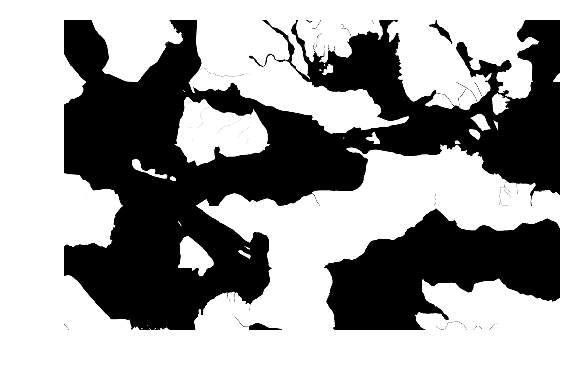

FileNotFoundError: [Errno 2] No such file or directory: '../results/stitching/128x128_21_03_1108_8x5.png'

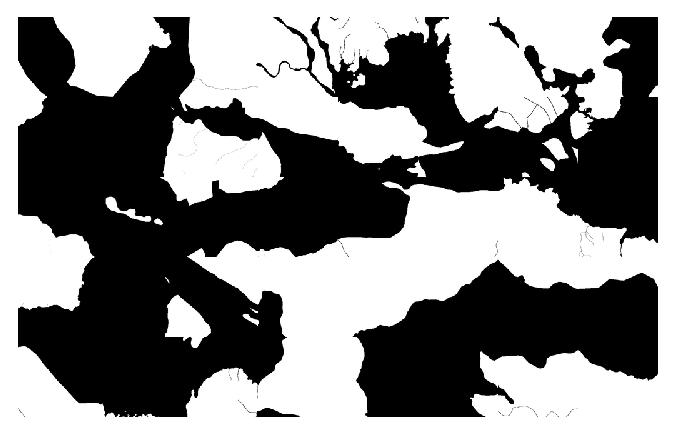

In [25]:
tiles_w = 8

#while tiles_w < 31:
tiles_h = round(tiles_w * (2/3))

indices = np.zeros((tiles_w, tiles_h))
canvas = generate_map(tiles_w, tiles_h)
save_map(canvas)
# tiles_w += 1
# tiles_h += 1